In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
d90_file = '../results/complexity_utf-16_1010_10_10_bibles_90_lcm.csv'
dall_file = '../results/complexity_utf-16_2020_10_10_bibles_lcm.csv'

In [3]:
def load_and_process(path):
    df = pd.read_csv(path, index_col=False)
    # Remove Nambikuára due to it's tone annotation (read paper for more info)
    df = df[df.language != "NAMBIKUÁRA"]
    df.loc[df.metric == 'del-chars', 'value'] = - df.loc[df.metric == 'del-chars', 'value']

    metric_rename = {
        'del-chars'  : r'morphological deletion',
        'del-verses' : r'pragmatic deletion',
        'del-words'  : r'syntactic deletion',
        'rep-words'  : r'morphological substitution',
        'do-nothing' : r'size'
    }

    df.replace(metric_rename, inplace=True)

    return df

In [4]:
df90 = load_and_process(d90_file)
dfall = load_and_process(dall_file)

family = pd.read_csv('../dataset/family.csv', index_col=None)

In [5]:
def h1(df):
    unique_algorithms = list(df.algorithm.unique())
    out = {}
    for algorithm in unique_algorithms:
        ag = df.algorithm == algorithm
        nn = df.algorithm == 'none'
        sz = df.metric == 'size'
        rw = df[sz & nn]
        co = df[sz & ag]

        x = rw.sort_values('language').value.to_numpy()
        y = co.sort_values('language').value.to_numpy()
        lr = sp.stats.linregress(x, y)
        ỹ = lr.slope*x + lr.intercept
        oc = y - ỹ
        # oc - overall complexity
        # rw - size of the original text
        # co - size of the original text compressed (no degradation)
        out[algorithm] = (
            pd.DataFrame(dict(language=list(rw.sort_values('language').language),
                              oc=oc, rw=x, co=y)),
            x,
            ỹ
        )
    return out

/tmp/ipykernel_1931/1727078790.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipykernel_1931/1727078790.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


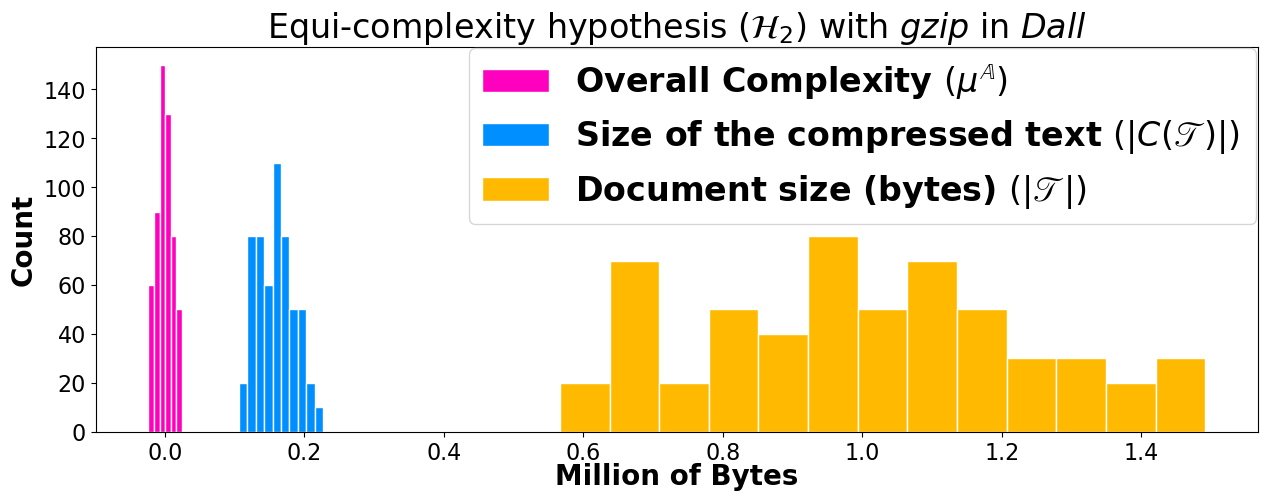

In [6]:
def ploth2old(outdf, algorithm, text):
    fig, ax = plt.subplots()
    fig.suptitle(f"Overall Complexity Distribution through the Evaluated Languages for {text} Subset")
    ax.hist(x='oc', bins=10, data=outdf['gzip'][0], label='gzip')
    ax.hist(x='oc', bins=10, data=outdf['bz2'][0], label='bz2', alpha=0.7)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Count')
    ax.legend()

def ploth2(df, dataset, algo):
    data = df[algo][0]
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(r"Equi-complexity hypothesis ($\mathcal{H}_2$) with $\it{%s}$ in $\it{%s}$" % (algo.lower(), dataset), fontsize=24)

    #ax.hist(x='oc', bins=6, data=data, label="Overall Complexity", edgecolor="#FF00BF", color="#FFD6E0")
    ax.hist(x='oc', bins=6, data=data, label=r"Overall Complexity $(\mu^{\mathbb{A}})$", edgecolor="white", color="#FF00BF")
    #ax.hist(x='co', bins=10, data=data, label="Size of the compressed text (bytes)", edgecolor="#008FFF", color="#90F1EF")
    ax.hist(x='co', bins=10, data=data, label=r"Size of the compressed text $(|C(\mathscr{T})|)$ ", edgecolor="white", color="#008FFF")
    #ax.hist(x='rw', bins=13, data=data, label="Document size (bytes)", edgecolor="#009B8C", color="#C1FBA4")
    ax.hist(x='rw', bins=13, data=data, label=r"Document size (bytes) $(|\mathscr{T}|)$", edgecolor="white", color="#FFBA00")

    #ax.set_title(, fontsize=24, pad=30)
    ax.set_xlabel("Million of Bytes", fontsize=20, weight="bold", labelpad=-1)
    ax.set_ylabel("Count", fontsize=20, weight="bold")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)

    legend = fig.legend(loc='upper right', bbox_to_anchor=(.91, .91), prop={'weight' : 'bold', 'size' : '24'})
    legend.get_title().set_fontsize('x-large')
    fig.savefig("../images/h2.pdf")

ploth2(h1(dfall), "Dall", "gzip")